# Doğrusal Olmayan Regresyon Modelleri

In [5]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

## K-En Yakın Komşu (KNN)

Tahminler gözlem benzerliğine göre yapılır. Parametrik olmayan bir öğrenme türüdür.
 * Komşu sayısını belirle (K)
 * Bilinmeyen nokta ile diğer tüm noktalara arasındaki uzaklıkları hesapla
 * Uzaklıkları sırala ve belirlenen k sayısına göre en yakın olank gözlemi seç
 * Sınıflandırma ise en sık sınıf, regresyon ise ortalama değeri tahmin değeri olarak ver.

#### Model

In [5]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [6]:
# Model Kurma
knn_model = KNeighborsRegressor().fit(X_train, y_train)

In [9]:
# Model Hiperparametresi (Komşuluk sayısı)
knn_model.n_neighbors

5

#### Tahmin

In [13]:
# Test seti için tahmi nedilen y değerleri
knn_model.predict(X_test)   

array([ 510.3334,  808.3334,  772.5   ,  125.5   , 1005.    ,  325.5   ,
        216.5   ,  101.5   ,  982.    ,  886.6666,  590.    ,  901.6666,
        831.6666,  157.5   ,  393.    , 1005.    ,  735.5   ,   97.    ,
        884.4   ,  302.    ,  450.    ,  817.6666,  832.6666,  392.3334,
        528.    ,   81.6   ,  735.    ,  470.    ,  722.5   ,  101.    ,
         90.5   ,   74.6   ,  748.3334,  217.    ,  280.5334, 1044.5   ,
        955.    ,  232.    ,   78.6   ,  529.    ,   77.6   ,  106.5   ,
        516.6666,  593.6666, 1005.    ,  649.1666,  715.    ,  101.5   ,
        134.5   ,  810.    ,  743.    ,  521.3334,  664.3334,  195.    ,
        102.4   ,  728.5   ,  488.    ,  962.5   ,  230.8334, 1040.    ,
        885.    ,  542.    ,  720.4   ,  571.    ,  735.    ,   81.6   ])

In [15]:
# Test hatası
y_pred = knn_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

426.6570764525201

Farklı k değerlerine karşılık olarak KNN farklı tahmin değerleri olacaktır. Bunları örnek olması için gözlemleyelim.

In [16]:
RMSE = []    #rmse değerlerini tutmak için boş bir liste oluşturuyoruz.

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)   # her iterasyonda k'ya göre model fit etme
    y_pred = knn_model.predict(X_train)     # eğitim seti üzerinde tahmin işlemi gerçekleştirme
    rmse = np.sqrt(mean_squared_error(y_train,y_pred))   # tahmin işlmelerine göre eğitim hatası 
    RMSE.append(rmse)   # bulunan eğitim hatası değerlerini listeye ekleme
    print("k =" , k , "için RMSE değeri: ", rmse)

k = 1 için RMSE değeri:  0.0
k = 2 için RMSE değeri:  179.52761335480352
k = 3 için RMSE değeri:  205.20157172291863
k = 4 için RMSE değeri:  220.5139794876305
k = 5 için RMSE değeri:  239.64671325413764
k = 6 için RMSE değeri:  243.5904190007242
k = 7 için RMSE değeri:  258.1478781634636
k = 8 için RMSE değeri:  266.05374203349805
k = 9 için RMSE değeri:  269.73782093553376
k = 10 için RMSE değeri:  271.2798300436963


#### Model Tuning

Şimdi burada Cross-Validation yöntemini işin içine koyarak farklı k değerlerine karşılık olacak şekilde nasıl bir seçim işlmei yapacağımızı ele alacağız. 

GridSearchCV metodu ile optimum k sayısını belirleme işlemi gerçekleştireceğiz.

GridSearch bir ızagra mantığı ile olası bir parametre setinin verilip tüm olası kombinasyonların denenmesi anlamına gelir.

In [17]:
from sklearn.model_selection import GridSearchCV

In [19]:
# KNN parametreleri oluşturma
knn_params = {'n_neighbors': np.arange(1,30,1)}

In [20]:
# Model nesnesi oluşturma
knn = KNeighborsRegressor()

In [21]:
knn_cv_model = GridSearchCV(knn, knn_params, cv=10)

In [22]:
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [23]:
# en uygun parametreyi bulma
knn_cv_model.best_params_["n_neighbors"]

8

In [25]:
# Valide edilmemiş ve Valide edilmiş rmse değerleri karşılaştırması

RMSE = [] 
RMSE_CV = []

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    
    rmse = np.sqrt(mean_squared_error(y_train,y_pred))  # valilde edilmemiş rmse değeri
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model, X_train, y_train, cv=10, 
                                         scoring = "neg_mean_squared_error").mean())   # valide edilmiş rmse değeri
    RMSE.append(rmse) 
    RMSE_CV.append(rmse_cv)
    print("k =" , k , "için RMSE değeri: ", rmse, "RMSE_CV değeri: ", rmse_cv )

k = 1 için RMSE değeri:  0.0 RMSE_CV değeri:  325.39475147063825
k = 2 için RMSE değeri:  179.52761335480352 RMSE_CV değeri:  293.24000183333817
k = 3 için RMSE değeri:  205.20157172291863 RMSE_CV değeri:  283.7486667487823
k = 4 için RMSE değeri:  220.5139794876305 RMSE_CV değeri:  286.3240222024089
k = 5 için RMSE değeri:  239.64671325413764 RMSE_CV değeri:  290.0705466132226
k = 6 için RMSE değeri:  243.5904190007242 RMSE_CV değeri:  298.1263115575851
k = 7 için RMSE değeri:  258.1478781634636 RMSE_CV değeri:  294.77070479194987
k = 8 için RMSE değeri:  266.05374203349805 RMSE_CV değeri:  291.98672028891235
k = 9 için RMSE değeri:  269.73782093553376 RMSE_CV değeri:  295.7162739573105
k = 10 için RMSE değeri:  271.2798300436963 RMSE_CV değeri:  301.31047022701154


In [28]:
# Final Modeli Nesnesi
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])

In [31]:
# Fit etme 
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [36]:
# Tuned edilmiş test hatası hesaplama
y_pred = knn_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

413.7094731463598

## Destek Vektör Regresyonu (SVR)

**Amaç,**bir marjin aralığına maksimum noktayı en küçük hata ile alabilecek şekilde doğru ya da eğriyi belirlemektir. Çıkışı itibariyle sınıflandırma problemleri için ortaya çıkmış ve sonrasında regresyon problemlerini de uygulanmıştır.

In [38]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [40]:
# Test-Train seti için değişkeni Hits olarak seçiyoruz.
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

#### Model

In [2]:
from sklearn.svm import SVR

In [42]:
svr_model = SVR("linear").fit(X_train, y_train)

In [46]:
# y bağımlı değişkenin tahmin edilen değerleri
svr_model.predict(X_train)[0:5]

array([403.52804878, 666.91219512, 706.66829268, 194.80853659,
       423.40609756])

In [48]:
# sabit katsayı
svr_model.intercept_

array([-48.69756098])

In [52]:
# bağımsız değişken katsayısı
svr_model.coef_[0][0]

4.969512195122206

In [56]:
# SVR'ın regresyona benzer olan formun- model denklemi
print ("y = {0} + {1} x".format(svr_model.intercept_[0], 
                                svr_model.coef_[0][0]))

y = -48.69756097561513 + 4.969512195122206 x


Hits değişkenin ilk değerini yukarıdaki formülde yerine koyduğumuz zaman tahmin edilen y bağımlı değişkenin ilk değerini hesaplayabiliriz.

In [57]:
X_train["Hits"][0:1]

183    91.0
Name: Hits, dtype: float64

In [59]:
-48.69756097561513 + 4.969512195122206 * 91

403.5280487805056

Doğrusal SVR'ın bir geometrik olarak ne ifade ettiğine bakalım. Basit bir SVR şuan sadece tek bir değişkenimiz var.

In [61]:
y_pred = svr_model.predict(X_train)

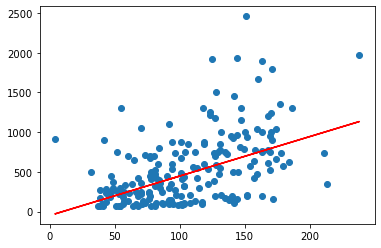

In [62]:
plt.scatter(X_train, y_train)
plt.plot(X_train, y_pred, color = "r")

In [63]:
# Doğrusal Regresyonun formülasyonu

from sklearn.linear_model import LinearRegression
lm_model = LinearRegression().fit(X_train, y_train)
lm_pred  = lm_model.predict(X_train)
print("y = {0} + {1} x".format(lm_model.intercept_, lm_model.coef_[0]))


y = -8.814095480334345 + 5.172456135470686 x


Şimdi Hits değişkenin ilk değerini bu formülde yerine yazalım.

In [64]:
-8.814095480334345 + 5.172456135470686 * 91

461.87941284749803

Yukarıda görüldüğü üzere doğrusal regresyon Salary bağımsız değişkeni için daha yüksek bir değer vermektedir.

İkiside aynı işlemi yapan iki farklı algoritma. Tek bir birim bazında ikisinden de bir tahmin sonucu bekledik. Bu farklılığın neden gerçekleştiğini gözlemleyeceğiz. İki modelin de oluşturduğu model denklemini üst üste koyarak bir gözlem yapalım.

Text(0, 0.5, 'Maaş (Salary)')

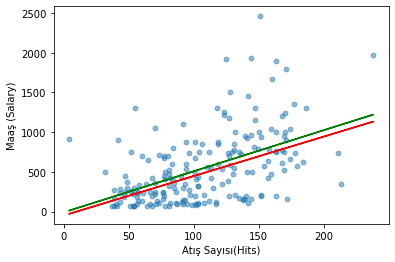

In [65]:
plt.scatter(X_train, y_train, alpha=0.5, s=23)
plt.plot(X_train, lm_pred, 'g')
plt.plot(X_train, y_pred, color='r')

plt.xlabel("Atış Sayısı(Hits)")
plt.ylabel("Maaş (Salary)")

Kurmuş olduğumuz algoritmalar da lineer model daha yukarıda tahmin vermişti. Bu grafikte **yeşil** renk ile gösterilen kısım Doğrusal regresyon, **kırmızı** renk ile gösterilen ise SVR 

Bu iki doğru arasında fark olma sebebi SVR'ın **robust** olmasıdır. Aykırı gözlemler lineer modeli yani eğriyi yukarı doğru çekmektedir. SVR'da ise bu aykırı gözlemlerin etkisi düşüktür ve direnç gösterir.

#### Tahmin

In [68]:
# sabit katsayı ve bağımsız değişken katsayısı ile modelin tahmin denklemi
print ("y = {0} + {1} x".format(svr_model.intercept_[0], svr_model.coef_[0][0])) 

y = -48.69756097561513 + 4.969512195122206 x


In [70]:
# Model içerisine bir değer koyarak tahminde bulunma 
svr_model.predict([[91]])

array([403.52804878])

In [72]:
# test hatası
y_pred = svr_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

459.0187960365147

#### Model Tuning

Burada tuned etmemiz gereken parametre C karmaşıklık(ceza) parametresidir.

In [75]:
svr_params = {'C': np.arange(0.1,2,0.1)}
svr_cv_model = GridSearchCV(svr_model, svr_params, cv=10).fit(X_train, y_train)

In [77]:
# Önerilen en iyi parametre değeri
svr_cv_model.best_params_

# Değeri pandas series ile alma
pd.Series(svr_cv_model.best_params_)[0]

0.1

In [78]:
# Final modeli
svr_tuned = SVR("linear", C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

In [84]:
# Tuned edilmiş model üzerinden tahmin edilen y değerleri
svr_tuned.predict(X_test)

array([ 620.26418033,  674.06202459,  620.26418033,  424.63565574,
        155.64643443,  292.58640164,  771.87628689,  683.84345082,
        732.75058197,  297.47711475,  698.51559016,  605.59204098,
        170.31857377,  664.28059836,  424.63565574,  507.77777869,
        923.48839344,  312.1492541 ,  967.50481148,  512.6684918 ,
        317.03996721, 1045.75622131,  522.44991803,  561.57562295,
        933.26981967,  238.78855738,  708.29701639,  361.05638525,
        287.69568852,  180.1       ,  248.56998361,  -39.98209016,
        326.82139344,  542.01277049,  287.69568852,  400.18209016,
        678.9527377 ,  542.01277049,   87.17645082,  214.3349918 ,
        155.64643443,  507.77777869,  542.01277049,  493.10563934,
        625.15489344,  678.9527377 ,  209.44427869,  488.21492623,
        532.23134426,  742.5320082 ,  644.7177459 ,  229.00713115,
        850.12769672,  625.15489344,  321.93068033,  727.85986885,
        493.10563934,  297.47711475,  111.63001639,  625.15489

In [85]:
# Tuned edilmiş model üzerinden test hatası hesaplama
y_pred = svr_tuned.predict(X_test)
np.sqrt(mean_squared_error(X_test, y_pred))

433.50582685399695

## Doğrusal Olmayan SVR

#### Model

In [10]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [15]:
# Model Kurma
svr_rbf = SVR("rbf").fit(X_train, y_train)

#### Tahmin

In [16]:
# Test seti üzerinden tahmin edilen y bağımlı değişken değerleri
svr_rbf.predict(X_test)

array([467.17641555, 446.40313543, 478.61634896, 407.90736132,
       478.21333994, 417.12254646, 409.5369652 , 406.6833667 ,
       475.87387807, 472.35514043, 437.62371823, 470.87017269,
       475.61088446, 409.98015887, 417.76687494, 478.43331711,
       433.90433249, 405.3784308 , 449.34132456, 417.20961012,
       467.52126683, 429.7970886 , 429.27433039, 425.64037296,
       419.74184952, 403.04020294, 478.12867963, 419.46502593,
       467.98640388, 405.00840939, 404.35642525, 402.66487856,
       443.78645366, 412.97944034, 411.32083923, 478.8961275 ,
       471.79125748, 410.33130924, 403.32692238, 426.9544654 ,
       403.64557418, 404.74733617, 454.74782229, 433.10191289,
       478.70972915, 459.9497864 , 477.55417184, 405.01026337,
       408.92637939, 426.28903835, 472.7745124 , 446.66776352,
       441.59170843, 412.58392272, 406.04166734, 438.41225906,
       451.95520339, 476.94220443, 407.53571839, 475.58095683,
       472.51311483, 420.0614604 , 453.93699692, 421.10

In [17]:
# Test hatası
y_pred = svr_rbf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

460.0032657244849

#### Model Tuning

In [24]:
# GridSearch ile model ve parametreleri kullanarak optimum ceza parametresini bulma
svr_params = {"C": [0.01, 0.1,0.4,5,10,20,30,40,50]}   # parametre seti oluşturma
svr_cv_model = GridSearchCV(svr_rbf,svr_params, cv = 10)
svr_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 0.4, 5, 10, 20, 30, 40, 50]})

In [25]:
svr_cv_model.best_params_

{'C': 50}

In [26]:
pd.Series(svr_cv_model.best_params_)[0]

50

In [27]:
# Final Modeli
svr_tuned = SVR("rbf", C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

In [29]:
# Tuned edildikten sonra tahmin edilen y bağımlı değişken değerleri
svr_tuned.predict(X_test)

array([802.04131677, 645.23557028, 839.14962266, 167.90440567,
       827.97310997, 317.94869806, 205.70209193, 141.95252898,
       845.36743802, 748.80827602, 565.71102494, 740.93268156,
       774.82832687, 201.68659533, 331.4091879 , 832.13254486,
       534.97643105, 122.96132251, 678.36149089, 315.95503716,
       796.19638417, 490.18278807, 482.94325414, 427.50657068,
       361.52413936,  74.12671747, 822.22950599, 354.53945377,
       819.40287369, 117.79503797, 101.38387319,  53.05651885,
       616.3390817 , 257.1187028 , 234.3504853 , 850.35994665,
       756.87284025, 216.2802222 ,  80.09206766, 445.22079912,
        88.9767928 , 114.65320112, 722.27236325, 521.57127579,
       853.77358984, 753.90881922, 826.22056764, 118.71620185,
       187.36542475, 446.68654298, 834.78244845, 649.34386463,
       604.99596879, 244.57185436, 142.3527105 , 581.14481506,
       695.93149468, 796.6878129 , 168.92606362, 796.5260448 ,
       769.95800404, 366.24880495, 717.08683686, 377.63

In [30]:
# Test Hatası
y_pred = svr_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

428.00406888095694

## Yapay Sinir Ağları (Artificial Neural Networks) - YSA

İnsan beyninin bilgi işleme şeklini referans alan sınıflandırma ve regresyon problemleri için kullanılabilen kuvvetli makine öğrenmesi algoritmalarından birisidir.

### Çok Katmanlı Algılayıcı (Multilayer Perceptron)

#### Model

In [2]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state=42)

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
# Dönüştürme işlemi
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [5]:
X_train_scaled = scaler.transform(X_train)

In [87]:
X_test_scaled = scaler.transform(X_test)

In [94]:
# Model Kurma
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes = (100,20)).fit(X_train_scaled, y_train)

In [95]:
# Katman sayısına ulaşma    -- Girdi,Gizli,Çıktı Katmanları
mlp_model.n_layers_

4

In [96]:
# Gizli katman içerisindeki eleman sayısı 
mlp_model.hidden_layer_sizes

(100, 20)

#### Tahmin

In [99]:
mlp_model.predict(X_train_scaled) [0:5]

array([ 52.41579922, 339.8434854 , 206.56619383,  37.82690351,
        36.70113449])

In [114]:
# Test hatası
y_pred = mlp_model.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

496.83668622707864

#### Model Tuning

Bir yapay sinir ağı modeli kurmak istediğimizde gizli katman sayısını ifade etmenin yolu bu argümana katmanların eleman sayısını girmektir. Her bir yeni eleman sayısı ekleme işlemi yapıldığında bunu katman eklenmesi oalrak algılar. 

In [102]:
# Deneme parametreleri oluşturma
mlp_params = {"alpha": [0.1, 0.01, 0.02, 0.005],
              "hidden_layer_sizes": [(20,20),(100,50,150),(300,200,150)],
               "activation":["relu","logistic"]}

In [104]:
# Model Oluşturma 
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv=10)

In [105]:
mlp_cv_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=MLPRegressor(hidden_layer_sizes=(100, 20)),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(20, 20), (100, 50, 150),
                                                (300, 200, 150)]})

In [108]:
# Optimum parametleri seçme işlemi
mlp_cv_model.best_params_

{'activation': 'relu', 'alpha': 0.02, 'hidden_layer_sizes': (100, 50, 150)}

In [110]:
# Final Modeli
mlp_tuned = MLPRegressor(alpha = 0.02, hidden_layer_sizes = (100, 50, 150))

In [112]:
mlp_tuned.fit(X_train_scaled, y_train)

MLPRegressor(alpha=0.02, hidden_layer_sizes=(100, 50, 150))

In [113]:
# Test hatası
y_pred = mlp_tuned.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

365.502377527701

## Classification and Regression Tree(CART)

Sınıflandırma ve regresyon ağaçlarından **amaç**, veri seti içerisindeki karmaşık yapıları basit karar yapılarına dönüştürmekdir.Heterojen veri setleri belirlenmiş bir hedef değişkene göre homojen alt gruplara ayrılır.

#### Model

In [2]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [3]:
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

In [4]:
# Model Oluşturma
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
cart_model = DecisionTreeRegressor(max_leaf_nodes = 10)
cart_model.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=10)

In [19]:
# Dallanmaların ve kırılmaların örnek görselleştirmesi

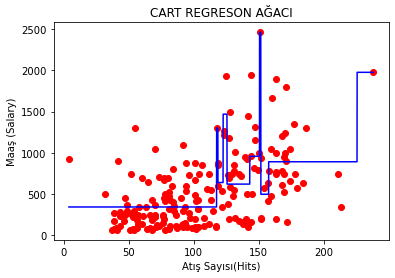

In [5]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1))  
plt.scatter(X_train, y_train, color = 'red') 
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ;

**Oluşturduğumuz model içerisindeki max_leaf_nodes argümanın değiştirerek model üzerindeki bölme işlemlerini görebiliriz.** Bizim burdaki amacımız algoritma da bu parametreyi optimum değerde olması gerektiği bilgisini bulmaktır.

In [23]:
# Ağacın oluşturduğu kural setini üretme

In [21]:
pip install skompiler

Note: you may need to restart the kernel to use updated packages.


In [7]:
from skompiler import skompile

In [20]:
pip install astor

Note: you may need to restart the kernel to use updated packages.


In [8]:
print(skompile(cart_model.predict).to('python/code'))

(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)



Yukarıdaki çıktı karar ağacının karar modelidir.Bu kural yerleştirildiğinde buraya gelecek olan x değerleri neticesinde bir tahmin etme işlmei gerçekleşmiş olacaktır.

#### Tahmin

In [24]:
x = [91]

In [25]:
(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)

345.2011551724138

In [9]:
cart_model.predict(X_test)[0:5]

array([621.96792308, 958.61111111, 621.96792308, 345.20115517,
       345.20115517])

In [10]:
cart_model.predict([[91]])

array([345.20115517])

In [11]:
# Test hatası
y_pred = cart_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

486.34593105235456

#### Model Tuning

In [19]:
# Modelimizi bir önüne getirelim ve bazı parametreli değiştirerek neler olacağını gözlemleyelim
cart_model = DecisionTreeRegressor(max_leaf_nodes = 15)
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [20]:
np.sqrt(mean_squared_error(y_test, y_pred))

455.8367349677217

max_leaf_nodes sayımız başlangıçta model kurarken rastgele olarak 10 vermiştik ve test hatası olarak 469 değerini almıştık.Burada görüleceği üzere max_leaf_nodes sayısını 15 yaptığımızda test hata değermimiz 455 oldu.

In [25]:
# İlave bir paremetre daha ekleyerek değişime bakalım
cart_model = DecisionTreeRegressor(max_leaf_nodes = 15, min_samples_split = 10)
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [26]:
np.sqrt(mean_squared_error(y_test, y_pred))

458.44092458608196

Yukarıdaki parametre değerlerini değiştirdiğimiz de test hatasının değerinin değiştiğini göreceğiz.

**Şimdi optimum parametre değerlerini bulmak için GridSearch ile Cross-Validation işlemi yapacağız.**

In [30]:
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}

In [31]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv=10)

In [34]:
cart_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_leaf_nodes=15,
                                             min_samples_split=10),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [ ]:
cart_cv_model.best_params_

In [35]:
# Final Modeli
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = 9, min_samples_split = 76)

In [36]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=9, min_samples_split=76)

In [38]:
# Test Hatası
y_pred = cart_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

423.406689243066

Tek değişken üzerine kurmuş olduğumuz algoritmada iyileştirilmiş test hatası değeri budur. Tüm değişkeleri kullanarak bir işlem yaptığımızda açıklanabilirlik ve test hatası değeri değişkenlik gösterecektir.

## Bagged Trees

**Bagging:**Temeli bootstrap yöntemi ile oluşturulan birden fazla karar ağacının ürettiğini tahminlerin bir araya getirilerek değerlendirilmesine dayanır.

### Topluluk Öğrenme Yöntemleri
**Internal:**Modellerin kendi içerisinde topluluk öğrenme yapısını taşımasıdır.Kendi içinde birden fazla ağaç bulunmasıdır.

**External**:Bir den farklı algoritmaların bir araya gelip bu algoritmaların beraber bir modelleme problemi üzerinde çalışmasıdır.

#### Model

In [53]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [54]:
# Model Kurma
from sklearn.ensemble import BaggingRegressor
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

Model içindeki otomatik parametrelerden n_estimators parametresi birbirinden farklı oluşturulan ağaçları ifade etmektedir.

In [43]:
# Model içindeki birbirinden farklı olan ağaçlar
bag_model.estimators_

[DecisionTreeRegressor(random_state=584355877),
 DecisionTreeRegressor(random_state=912744435),
 DecisionTreeRegressor(random_state=1087092102),
 DecisionTreeRegressor(random_state=1265543213),
 DecisionTreeRegressor(random_state=255610307),
 DecisionTreeRegressor(random_state=1476844017),
 DecisionTreeRegressor(random_state=320598283),
 DecisionTreeRegressor(random_state=1734224081),
 DecisionTreeRegressor(random_state=821586387),
 DecisionTreeRegressor(random_state=306091249)]

In [44]:
# Her bir ağaçta kaç tane örnek olduğu bilgisi
bag_model.estimators_samples_

[array([ 34,  64, 154,  48,  35, 123, 128,  90, 190,  70,  46,  13,  11,
        180,  53,  55, 141, 166, 167, 186,  55,   1, 132,  13,  37, 126,
         65,  29,  43,  74,  72,  89, 188,  46, 129, 191, 188, 137,  95,
         31,  26,  98, 174, 119,  91,  98,  41, 106, 112,  19,  26,  76,
        110, 140, 172,  87, 131,  91,  75, 144,  62, 188,  32,  28, 182,
         95,  23, 112, 158, 170, 133,  73,  81, 127, 116, 152,  21, 138,
         65, 130,  10,   3, 109, 114,  53, 116,  96, 100,  80, 125, 137,
         67, 147, 136, 195, 148, 110,  93,  62, 192,  75,  18,  82, 175,
         21, 135,  22, 173,  45, 131, 186, 102, 102,  35,  21,  56,  55,
         42,  72,  82,  84,  31, 153,  99,  49, 118, 143,  32, 112, 101,
        139,  19,  38, 140,  60,  83, 171, 138,  29, 156, 147, 148,  80,
         17,  60, 173, 174,  60, 188,  18, 180, 101,  48, 169,  11, 175,
        159,  85, 172,  37,  35,  49, 144,  58,  10,  93, 195,  13, 113,
        139,  89,  40, 196,  64,  42,  62,  22,  93

In [45]:
# Her bir ağacın bağımsız değişkenleri
bag_model.estimators_features_

[array([ 5, 17,  6,  8, 12, 13, 14,  6, 12,  9, 12, 10, 17,  5,  7, 18, 18,
         9, 12]),
 array([11, 12, 10,  8, 17, 15,  7,  5,  2, 16,  1,  9,  8, 14, 13, 15, 17,
        17,  8]),
 array([ 6, 12, 15, 11,  8, 12, 12,  3,  5,  7,  1, 13,  3, 17, 17, 17,  0,
         0, 18]),
 array([13, 15,  3, 10,  7, 12,  6,  1, 11, 13, 18,  1, 13, 12, 18, 12,  3,
        16,  5]),
 array([ 3, 11, 15, 17,  4, 12,  3, 17, 17,  8,  1,  6,  9,  4, 12,  9, 10,
         4,  2]),
 array([17,  2,  6, 13,  5,  0,  6, 18,  3,  5,  8, 18,  6,  6,  6, 10, 10,
        16,  7]),
 array([11,  5, 11, 12, 13, 11,  8, 16, 16, 11,  6,  7, 17,  0, 16, 12, 14,
        18,  2]),
 array([17,  6,  1,  7,  3, 17,  6, 13, 13,  6,  8,  6,  0,  7,  2,  0, 12,
         4,  2]),
 array([ 6, 14,  5,  8,  4, 10,  5,  9, 10,  0, 14, 10, 13, 14, 15, 18,  6,
         7, 14]),
 array([17,  8,  1, 11, 10, 18, 10, 16, 14,  9, 15,  4,  3, 16,  7,  9,  2,
        13, 14])]

#### Tahmin

In [55]:
# Test Hatası(İlkel)
y_pred = bag_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

356.86799464185293

In [57]:
# Örneğin 2.ağaca gitmek (1.index)
iki_y_pred = bag_model.estimators_[1].fit(X_train, y_train).predict(X_test)

In [58]:
np.sqrt(mean_squared_error(y_test, iki_y_pred))

519.1710409833861

In [59]:
# Örneğin 7.ağaca gitmek
yedi_y_pred = bag_model.estimators_[6].fit(X_train, y_train).predict(X_test)

In [60]:
np.sqrt(mean_squared_error(y_test, yedi_y_pred))

443.40625602969646

#### Model Tuning

Bu kısımda yine **GridSearchCV** yaklaşımı ile tahminci sayısı değiştirerek durum gözlemlemesi yapacağız.

In [65]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [62]:
# Model Parametresi
bag_params = {"n_estimators": range(2,20)}

In [66]:
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)

In [67]:
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [68]:
bag_cv_model.best_params_

{'n_estimators': 7}

In [70]:
# Final Modeli
bag_tuned =  BaggingRegressor(n_estimators = 7, random_state = 45)

In [71]:
bag_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=7, random_state=45)

In [72]:
# Test Hatası
y_pred = bag_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

354.206758941082

## Random Forests (RF)

Temeli birden çok karar ağacının ürettiği tahminlern bir araya gelerek değerlendirilmesine dayanır.

 * Bagging ile Random Subspace yöntemlerinin birleşimi ile oluşmuştur.
 * Ağaçlar ile gözlemler bootstrap rastgele örnek seçim yöntemi ile **değişkenler random subspace yöntemi ile seçilir.**
 * Karar ağacının her bir düğümünde en iyi dallara ayırıcı(bilgi kazancı) değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişken arasında seçilir.
 * Ağaç oluşturmada veri setinin 2/3'ü kullanılır.Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin belirlenmesi için kullanılır.
 * Her düğüm noktasında rastgele değişken seçimi yapılır.(regresyon'da p/3, sınıflama'da karekök p)
 * Nihai tahmin için ağaçlardan tahmin değerleri talep edilirken her bir ağacın daha önce hesaplanan hata oranları göz önüne alınarak ağaçlara ağırlık verilir.

#### Model

In [73]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
# Model Oluşturma
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Random Forests'da önemli olan üç parametre vardır.
 * Fit edilecek ağaç sayısı (n_estimators)
 * Her bölünmeden göze alınacak olan değişken sayısı (max_feautures)
 * Ağacın maksimum derinlik sayısı (max_depth)

#### Tahmin

In [79]:
# Tahmin edilen y değerleri
rf_model.predict(X_test)[0:5]

array([ 740.62167,  895.99497, 1184.695  ,  139.65167,  634.75833])

In [80]:
# Test Hatası
y_pred = rf_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

345.00286717448006

#### Model Tuning

In [89]:
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000]}

In [90]:
# Model Oluşturma
rf_model = RandomForestRegressor(random_state = 42)

In [91]:
rf_cv_model = GridSearchCV(rf_model,
                         rf_params,
                         cv=10,
                         n_jobs = -1)

In [92]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000]})

In [88]:
rf_cv_model.best_params_

{'max_depth': 8, 'max_features': 3, 'n_estimators': 100}

In [93]:
# Final Modeli

In [96]:
rf_tuned = RandomForestRegressor(max_depth  = 8, 
                                 max_features = 3, 
                                 n_estimators =100)

In [97]:
rf_tuned = rf_tuned.fit(X_train, y_train)

In [98]:
# Test Hatası
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

341.3735827097043

In [99]:
# Değişkenlerin Önem Düzeyi

In [102]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

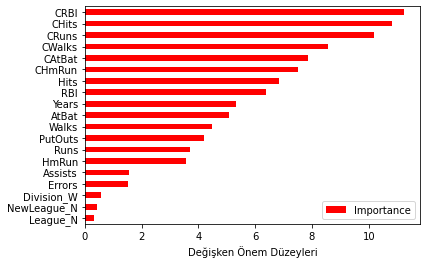

In [103]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

Yukarıdaki görsel değişkenlerin veri seti üzerinde ki önem düzeyini göstermektedir. Doğrusal regresyon da değişkenlerin önemlerine ilişkin bilgiler alabiliyorduk. Çıktıya baktığımız zaman değişkenler model için anlamlı mı değil mi ? Daha sonra bu değişkenlerin bağımlı değişkene olan katkılarını gözlemleyebiliyorduk.

## Gradient Boosting Machines (GBM)

AdaBoot'un sınıflandırma ve regresyon problemlerine kolayca uyarlanabilen genelleştirilmiş versiyonudur. Artıklar üzerine tek tahminsel model formunda olan modeller serisi kurulur.Bagging'de ağaçlar bağımsızdır,boosting yöntemlerinde ise ağaçların birbirine bağımlılığı söz konusudur.(iterative/kümalatif)

 * Seri içerisindeki bir model serideki bir önceki modelin tahmin artıklarının/hatalarının üzerine kurularak(fit) oluşturulur.
 * GBM diferansiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient descent algoritmasını kullanmakta.
 * GB bir çok teme löğrenci tipi(base learner type) kullanılabilir.
 * Cost fonksiyonları ve link fonksiyonları modifiye edilebilirdir.
 * Boosting + Gradient Descent

**Boosting Yöntemlerine Giriş**

Zayıf öğrenicileri bir araya getirip güçlü bir öğrenici ortaya çıkarmak fikrine dayanır.

**Adaptive Boosting(AdaBoost):** Zayıf sınıflandırıcıların bir araya gelerek güçlü bir sınıflandırıcı oluşturması fikrini hayata geçiren algoritmadır.

#### Model

In [6]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

In [8]:
# Model Kurma
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

GBM kullanırken kullanmış olduğumuz algoritma hem ağaca dayalı bir yöntem olabilir hem de lineer bir yöntem olabilir.Bu kısımda biz ağaca dayalı yöntem şeklinde kullanacağız.

#### Tahmin

In [10]:
# Test Hatası
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

352.20812653916516

#### Model Tuning

In [11]:
# Tuned edilecek olan parametreler
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8,50,100],
    'n_estimators': [200, 500, 1000],
    'subsample': [1,0.5,0.75],
}

In [12]:
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=10, n_jobs = -1, verbose = 2) #verbose:iterasyonları gözlemlemek için argüman
gbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 20.9min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8, 50, 100],
                         'n_estimators': [200, 500, 1000],
                         'subsample': [1, 0.5, 0.75]},
             verbose=2)

In [13]:
gbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.75}

In [19]:
# Final Modeli
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1,  
                                      max_depth = 3, 
                                      n_estimators = 500, 
                                      subsample = 0.75)

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [20]:
# Test Hatası
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

336.16833700096214

Text(0.5, 0, 'Değişken Önem Düzeyleri')

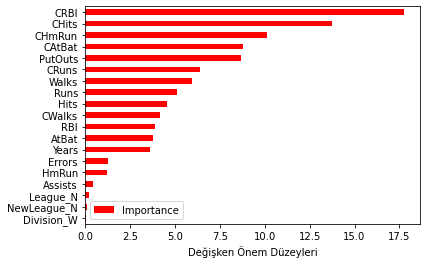

In [21]:
# GBM Değişken Önem Düzeyi
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

## XGBoost (eXtreme Gradient Boosting)

**XGBoost**,GBM'in hız ve tahmin performansını arttırmak üzere optimize edilmiş;ölçeklenebilir ve farklı platformlara entegre edilebilir.

 * R,Python,Hadoop,Scala ve Julia ile kullanılabilir.
 * Ölçeklenebilir ve hızlıdır.
 * Tahmin başarısı yüksektir.

#### Model

In [22]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [25]:
# XGB indirme işlemi
!pip install xgboost

Standart Pandas ya da Numpy yerine kendi veri yapısını kullanırsak daha performaslı sonuçlar elde edilebilir.

In [26]:
import xgboost as xgb

In [27]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

In [29]:
# Model Kurma
from xgboost import XGBRegressor
xgb_model = XGBRegressor().fit(X_train, y_train)

#### Tahmin

In [30]:
# Test Hatası
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

355.46515176059927

#### Model Tuning

In [33]:
# Model içerisindeki önemli olan parametreleri optimize etmek
xgb_params = {
     'colsample_bytree': [0.4, 0.5,0.6,0.9,1],  # ağaç başına değişkenlerden alınacak olan örnek oranı
     'n_estimators':[100, 200, 500, 1000],
     'max_depth': [2,3,4,5,6], # overfitting önüne geçmek için kullanılan ve karmaşıklık parametresi olarak aslında adlandırılan bir parametre
     'learning_rate': [0.1, 0.01, 0.5]  # daraltma adım boyu - overfitting engellemek için kulanılan değişkenlerden 0-1 arasında değer alması beklenir.
}

In [35]:
xgb = XGBRegressor()
xgb_cv_model = GridSearchCV(xgb,param_grid = xgb_params, cv=10, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.0min finished


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_par

In [36]:
xgb_cv_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 500}

In [37]:
# Final Modeli
xgb_tuned = XGBRegressor(colsample_bytree = 0.5, 
                         learning_rate = 0.1, 
                         max_depth = 2, 
                         n_estimators = 500) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)

In [39]:
# Test Hatası
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

346.0275204366939

## LightGBM

**Light GBM,** XGBoost'un eğitim süresi performansını arttırmaya yönelik geliştirilen bir diğer GBM türüdür.
 * Daha performaslı
 * Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisi
 * Breadth-first search (BFS) yerine depth-first-searh (DFS)
 
**XGBoost** değişkenleri ayırmak ve farklı bölme noktalarını araştırmak için karar ağaçlarını kullanılıyor. Bu işleme Level-wise büyüme stratejisi adı veriliyor. 

**Light GBM** daha iyi fit edebilmek için splitlere odaklanıyor buna da Leaf-wise büyüme stratejisi adı veriliyor.

Ağaç yapılarındaki bölme işlemleri düşünüldüğünde XGBoost daha geniş kapsamlı bir arama yapar, LightGBM ise derinlemesine ilk arama yapar.

#### Model

In [49]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [41]:
! pip install lightgbm

In [50]:
from lightgbm import LGBMRegressor

In [51]:
# Model Oluşturma
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)

LGBMRegressor()

#### Tahmin

In [52]:
# Test Hatası -- Diğerlerinden farklı olarak burada num_iteration isimli argüman kullanıyoruz.
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)
np.sqrt(mean_squared_error(y_test, y_pred))

363.8712087611089

#### Model Tuning

In [53]:
# Önemli olan hiperparametrelerden optimum olanı seçme
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [ ]:
lgbm_cv_model.fit(X_train, y_train)

In [ ]:
# Optimum Parametre değerleri
lgbm_cv_model.best_params_

In [ ]:
# Final Modeli
lgbm_tuned = LGBMRegressor(learning_rate = 0.1, 
                           max_depth = 7, 
                           n_estimators = 40,
                          colsample_bytree = 0.6)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train

In [ ]:
# Test Hatası
y_pred = lgbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

## CatBoost (Category Boosting)

Kategorik değişkenler ile otomatik olarak mücadele edilebilen,hızlı,başarılı bir diger GBM türüdür. Yandex tarafından 2017 yılında geliştirilmiştir.

 * Kategorik değişken desteği
 * Hızlı ve ölçeklenebilir GPU desteği
 * Daha başarılı tahminler
 * Hızlı train ve hızlı tahmin
 * Rusya'nın ilk açık kaynak kodlu başarılı ML çalışması

#### Model

In [55]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [56]:
!pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=bc09cb7dd964cb562058cff78dafdfb82ce646799f7d91c26a844e903748d173
  Stored in directory: c:\users\resul\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [57]:
from catboost import CatBoostRegressor

In [ ]:
# Model Oluşturma
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)

#### Tahmin

In [ ]:
# Test Hatası
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

#### Model Tuning

In [ ]:
# Uygun olan hiperparametre seçimi
catb_grid = {
    'iterations': [200,500,1000,2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3,4,5,6,7,8] }

In [ ]:
# Model Oluşturma
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=5, n_jobs = -1, verbose = 2)
catb_cv_model.fit(X_train, y_train)

In [ ]:
# En iyi parametre gözlem değerleri
catb_cv_model.best_params_

In [ ]:
# Final Modeli
catb_tuned = CatBoostRegressor(iterations = 200, 
                               learning_rate = 0.01, 
                               depth = 8)
​
catb_tuned = catb_tuned.fit(X_train,y_train)

In [ ]:
# Test Hatası
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))